# Libraries

In [175]:
!pip install svgwrite

In [176]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

import sys, os
py_file_location = "/content/gdrive/My Drive/AML6/"
sys.path.append(os.path.abspath(py_file_location))

Mounted at /content/gdrive/


In [177]:
import svgwrite
from IPython.display import display, SVG
import numpy as np
import random
import seaborn as sns

# Drawing function

In [178]:
palette = sns.color_palette('viridis', 101)
palette = [(int(p[0]*255),int(p[1]*255),int(p[2]*255)) for p in palette]

def draw(im, show=True, unit=10, depart=(0,0), goal=(29,9), paths=None, title='default.svg'):

    im = im*1.
    padding = 1.5 * unit
    size_x = (2*padding) + im.shape[0]*unit
    size_y = (2*padding) + im.shape[1]*unit
    dwg = svgwrite.Drawing(py_file_location+'_svg/'+title, size=(size_x, size_y))

    for i in range(im.shape[0]):
        for ii in range(im.shape[1]):

            g = int(im[i,ii])
            rgb = palette[g]
            color = svgwrite.rgb(*rgb)
            x, y = padding + (i*unit), padding + (ii*unit)
            tile = dwg.rect(insert=(x,y), size=(unit,unit)).fill(color)
            dwg.add(tile)

    agent_color = svgwrite.rgb(255, 0, 0)
    stroke = 2.
    t_unit = unit - stroke
    t_size = 3.

    if paths is not None:
        for path in paths:
          points = [(padding + (coo[0] * unit) + (0.5 * unit), padding + (coo[1] * unit) + (0.5 * unit)) for coo in path]
          #path = dwg.polyline(points=points, fill="none").stroke(color="white", width=stroke*3)
          #dwg.add(path)
          path = dwg.polyline(points=points, fill="none").stroke(color=agent_color, width=stroke)
          dwg.add(path)

    # departure and goal
    dpt_x, dpt_y = (unit * 0.5) + padding + depart[0] * unit, (unit * 0.5) + padding + depart[1] * unit
    dpt = dwg.circle(center=(dpt_x,dpt_y), r=t_unit*(t_size*0.8)).fill(agent_color).stroke(color="white", width=stroke)
    dwg.add(dpt)

    arr_x, arr_y = (unit * 0.5) + padding + goal[0] * unit, (unit * 0.5) + padding + goal[1] * unit
    pt1 = (arr_x + np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    pt2 = (arr_x, arr_y - (t_unit * t_size))
    pt3 = (arr_x - np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    points = [pt1, pt2, pt3]
    arrival = dwg.polygon(points=points).stroke(color="white", width=stroke).fill(agent_color)
    dwg.add(arrival)

    if show: display(SVG(dwg.tostring()))
    return dwg


# Create dataset

In [ ]:
from os import listdir
from os.path import isfile, join

directory = py_file_location+"xyz/"
onlyfiles = sorted([f for f in listdir(directory) if isfile(join(directory, f)) and f[0]!='.'])
print (onlyfiles)


['2585_1154.xyz', '2585_1164.xyz', '2585_1174.xyz', '2585_1184.xyz', '2585_1194.xyz', '2595_1154.xyz', '2595_1164.xyz', '2595_1174.xyz', '2595_1184.xyz', '2595_1194.xyz', '2605_1154.xyz', '2605_1164.xyz', '2605_1174.xyz', '2605_1184.xyz', '2605_1194.xyz', '2615_1154.xyz', '2615_1164.xyz', '2615_1174.xyz', '2615_1184.xyz', '2615_1194.xyz', '2625_1154.xyz', '2625_1164.xyz', '2625_1174.xyz', '2625_1184.xyz', '2625_1194.xyz', '2635_1154.xyz', '2635_1164.xyz', '2635_1174.xyz', '2635_1184.xyz', '2635_1194.xyz', '2645_1154.xyz', '2645_1164.xyz', '2645_1174.xyz', '2645_1184.xyz', '2645_1194.xyz']


In [ ]:
alts = []
tile = 50

for filename in onlyfiles:

    print (filename)

    with open(directory+filename, 'r') as f:

        data = f.readlines()
        data = [d.replace('\n','').split(' ') for d in data[1:]]
        data = [float(l[2]) for l in data]
        data = np.array(data)

    Z = data.reshape((1000, 1000))

    R = np.zeros((int(Z.shape[0]/tile), int(Z.shape[1]/tile)))

    for i in range(R.shape[0]):
        for ii in range(R.shape[1]):

            R[ii,i] = Z[i*tile:(i+1)*tile, ii*tile:(ii+1)*tile].mean()

    alts.append(R.copy())

print (len(alts), 'files')


In [ ]:
print (alts[0].shape)
l = alts[0].shape[0]

R0 = np.zeros((7*l, 5*l))

for i in range(len(alts)):

    x = i//5
    y = 5-(i%5)-1
    R0[x*l:(x+1)*l, y*l:(y+1)*l] = alts[i]

R0 -= R0.min()
R0 /= R0.max()
R0 *= 100

(20, 20)


# Dump data

In [ ]:
import json
with open(py_file_location+'data.json', 'w') as f:
    json.dump(R0.tolist(), f)

# Load data

In [179]:
import json
with open(py_file_location+'data.json', 'r') as f:
    R0 = np.array(json.load(f))

# Model

In [180]:
R = R0.astype(float)
M, N = R.shape
print (M, N)
R[:10,:10]

140 100


array([[1.75281993, 2.20349821, 0.39252358, 0.15336861, 0.71133869,
        0.23076356, 0.16866642, 0.43983484, 1.65302694, 0.87307158],
       [0.58090414, 0.47255528, 0.04671693, 0.43491874, 0.22772565,
        0.6004581 , 1.60256082, 2.76206971, 2.92373855, 2.1587637 ],
       [0.08492156, 0.        , 0.22637886, 1.78536252, 2.23335983,
        1.29959924, 2.39537604, 2.67993301, 2.91563045, 3.6655361 ],
       [1.44392988, 2.08848844, 1.56313176, 0.36974565, 2.09144632,
        1.60729964, 2.24995254, 3.73224531, 4.57911125, 4.62458586],
       [2.92843099, 3.0257302 , 1.89053942, 0.32816689, 1.72886461,
        1.80468822, 2.53349084, 4.67517871, 5.03885958, 4.84820338],
       [3.47580436, 2.7018153 , 0.59161521, 0.80221832, 2.13703483,
        2.27378303, 3.19624723, 5.59478938, 5.83952411, 5.28466859],
       [3.96621664, 3.2765628 , 1.95718909, 0.36537547, 0.65157426,
        1.94362269, 3.48488397, 6.00875739, 6.21767096, 5.98343997],
       [2.41159538, 2.28510227, 1.5661356

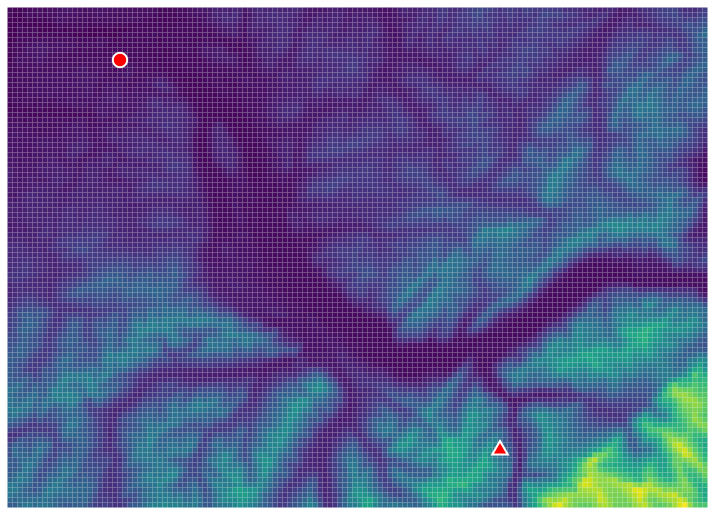

In [182]:
start_pos = (22, 10) # (22, 90)
end_pos =   (98, 88)
dwg = draw (R, depart=start_pos, goal=end_pos, unit=5, title="map.svg")
dwg.save()

In [183]:
# Define the environment
grid_size = (M, N)
rewards = R

# Define actions
actions = ['ur', 'ul', 'dr', 'dl']
action_to_index = {action: i for i, action in enumerate(actions)}

# Q-table initialization
Q_table = np.zeros((M, N, len(actions)))

# Hyperparameters
alpha = 0.005           # Learning rate
gamma = 0.9             # Discount factor
epsilon = 0.99          # Exploration rate
max_steps = 400         # Maximum steps per episode
num_episodes = 2000000  # Number of episodes for training

# Function to get the next state based on the current state and action
def get_next_state(state, action):
    x, y = state
    if action == 'ur': x -= 1; y += 1
    elif action == 'ul': x -= 1; y -= 1
    elif action == 'dr': x += 1; y += 1
    elif action == 'dl': x += 1; y -= 1
    return x, y

# Training the agent
scores = []
previous_reached = 0
reached = 0
last_z = 0

for episode in range(num_episodes):

    state = (random.choice(range(int(M/2.)))*2, random.choice(range(int(N/2.)))*2) # random state for generalization
    path = [state]
    total_reward = 0

    for step in range(max_steps):
        x, y = state

        # Choose action: epsilon-greedy strategy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = actions[np.argmin(Q_table[x, y])]  # Exploit

        # Get next state
        next_state = get_next_state(state, action)
        path.append(next_state)
        nx, ny = next_state

        # Check if next state is out of bounds
        if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
            reward = 10000
            total_reward += reward
            Q_table[x, y, action_to_index[action]] += alpha * (reward - Q_table[x, y, action_to_index[action]])
            break

        else:
            distance = ((nx-end_pos[0])**2 + (ny-end_pos[1])**2) ** 0.5
            reward = distance + (rewards[nx, ny] * distance * 1e-1)
            total_reward += reward

            Q_table[x, y, action_to_index[action]] += alpha * (
                reward + gamma * np.min(Q_table[nx, ny]) - Q_table[x, y, action_to_index[action]]
            )

            state = next_state

            if state == end_pos:
                reached += 1
                break

    scores.append(total_reward)

    if episode%100==0:
        #dwg = draw(R, depart=start_pos, goal=end_pos, unit=5, path=path, show=False, title=f"{int(episode/100.):05d}.svg")
        #dwg.save()
        pass

    if episode%25000==0:
        print (f"Episode {episode: 7d}, score {total_reward: 10.1f}, reached {reached - previous_reached: 5d}")
        previous_reached = reached

    # Optionally, decay epsilon to reduce exploration over time
    epsilon = max(0.1, epsilon * 0.999)

# The Q-table is now trained and can be used to determine the optimal policy

print ("total reached", reached)

Episode       0, score    98371.4, reached     0
Episode   25000, score     4724.9, reached  4163
Episode   50000, score    76508.2, reached  8013
Episode   75000, score    55033.6, reached  11485
Episode  100000, score      933.2, reached  14348
Episode  125000, score    54360.4, reached  16326
Episode  150000, score     6985.7, reached  17871
Episode  175000, score      984.6, reached  19029
Episode  200000, score      789.3, reached  20047
Episode  225000, score     1183.5, reached  20597
Episode  250000, score    25492.2, reached  21240
Episode  275000, score    18709.4, reached  21667
Episode  300000, score     8820.1, reached  22001
Episode  325000, score     2409.0, reached  22443
Episode  350000, score      929.0, reached  22635
Episode  375000, score     6922.2, reached  22814
Episode  400000, score     4433.7, reached  23031
Episode  425000, score     3262.0, reached  23142
Episode  450000, score    37707.2, reached  22737
Episode  475000, score     1903.0, reached  21623
Epi

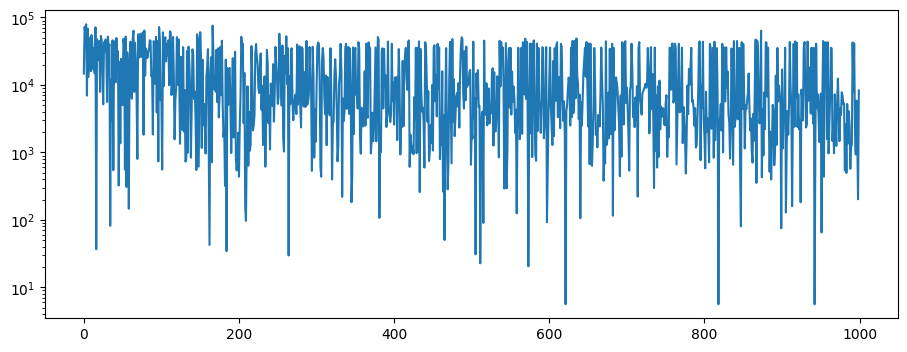

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11,4))
plt.yscale('log')
_ = plt.plot(scores[::2000])

Best score achieved : 5.621638239932911


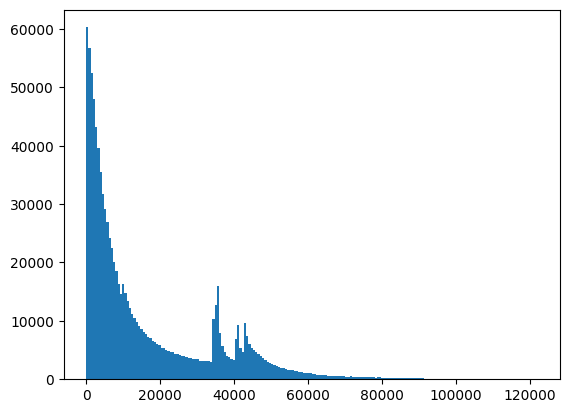

In [ ]:
_ = plt.hist(scores, 200)
print ('Best score achieved :', min(scores))

In [184]:
# Function to extract the optimal policy from the Q-table
def get_optimal_policy(Q_table):
    grid_size = Q_table.shape
    policy = np.full(grid_size[:2], '', dtype=object)

    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            # Choose the action with the minimum Q-value for each state
            best_action_index = np.argmin(Q_table[x, y])
            policy[x, y] = actions[best_action_index]

    return policy

# Function to simulate a run using the optimal policy
def simulate_policy(policy, start_state=start_pos, end_state=end_pos):

    state = start_state
    path = [state]
    total_reward = 0
    steps = 0
    last_z = 0

    while state != end_state and steps < max_steps:  # Stop if goal is reached or max steps exceeded
        x, y = state
        action = policy[x, y]
        next_state = get_next_state(state, action)

        # Check for out-of-bounds
        nx, ny = next_state
        if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
            total_reward += 10000  # Out-of-bounds penalty
            break

        # Add reward for the next state
        z = rewards[nx, ny]
        delta = abs(z - last_z)
        reward = delta
        total_reward += reward
        last_z = z

        state = next_state
        path.append(state)
        steps += 1

    return path, total_reward

In [185]:
# Derive the optimal policy
optimal_policy = get_optimal_policy(Q_table)

# Visualize the optimal policy
print("Optimal Policy :")
print (optimal_policy[0])
print ('...')

with open(py_file_location+'Q_table.json', 'w') as f:
  json.dump(Q_table.tolist(), f)

Optimal Policy :
['dr' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dr' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur'
 'dl' 'ur']
...


In [186]:
# Simulate a run using the optimal policy

print (len(R0.ravel()))

start_pos_list = []
for i in range(len(R0.ravel())):
  x = i%140
  y = i//140
  if x%2!=0 or y%2!=0: continue
  start_pos_list.append((x,y))

paths = []
for pos in start_pos_list:
  path, _ = simulate_policy(optimal_policy, start_state=pos, end_state=end_pos)
  paths.append(path)

dwg = draw (R, depart=start_pos, goal=end_pos, unit=5, paths=paths, title="all_paths.svg")
dwg.save()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Show that the best policy path is not necessarily the local minimum
# the model has a larger knowledge of the terrain

# Javascript

In [ ]:
print (paths[1500])

[(60, 42), (59, 43), (60, 44), (59, 45), (58, 46), (57, 47), (56, 48), (57, 49), (58, 50), (59, 51), (60, 52), (61, 53), (62, 54), (63, 55), (64, 56), (65, 57), (66, 58), (67, 59), (68, 60), (69, 61), (70, 62), (71, 63), (72, 64), (73, 65), (74, 66), (75, 67), (76, 68), (77, 69), (78, 70), (79, 71), (80, 72), (81, 73), (82, 72), (83, 71), (84, 72), (85, 71), (86, 72), (87, 71), (88, 70), (89, 71), (90, 70), (91, 69), (92, 70), (93, 71), (94, 72), (95, 73), (96, 74), (97, 75), (98, 76), (99, 77), (100, 78), (101, 79), (100, 80), (101, 81), (100, 82), (101, 83), (100, 84), (101, 85), (100, 86), (99, 87), (98, 88)]


In [ ]:
spaths = []

scale = 5
for path in paths:
  s = ""
  for coo in path:
    a, b = coo
    s += str(a*scale)+','+str(b*scale)+' '
  spaths.append(s)

print (len(spaths))
print (spaths)

Output hidden; open in https://colab.research.google.com to view.